## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dropout, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

## Data Loading

In [2]:
df = pd.read_csv('daily.csv')
df.head()

,Date,Price
0,1997-01-07,3.82
1,1997-01-08,3.80
2,1997-01-09,3.61
3,1997-01-10,3.92
4,1997-01-13,4.00


## Data Preprocessing

### Setup index with a date

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7128 entries, 1997-01-07 to 2025-05-19
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   7127 non-null   float64
dtypes: float64(1)
memory usage: 111.4 KB


### Handling Nan Values

mengecek nilai kosong

In [5]:
df.isna().sum()

,0
Price,1


In [6]:
df.dropna(subset=['Price'], inplace=True)

## EDA

In [7]:
df.describe()

,Price
count,7127.000000
mean,4.101621
std,2.168316
min,1.050000
25%,2.580000
50%,3.410000
75%,5.110000
max,23.860000


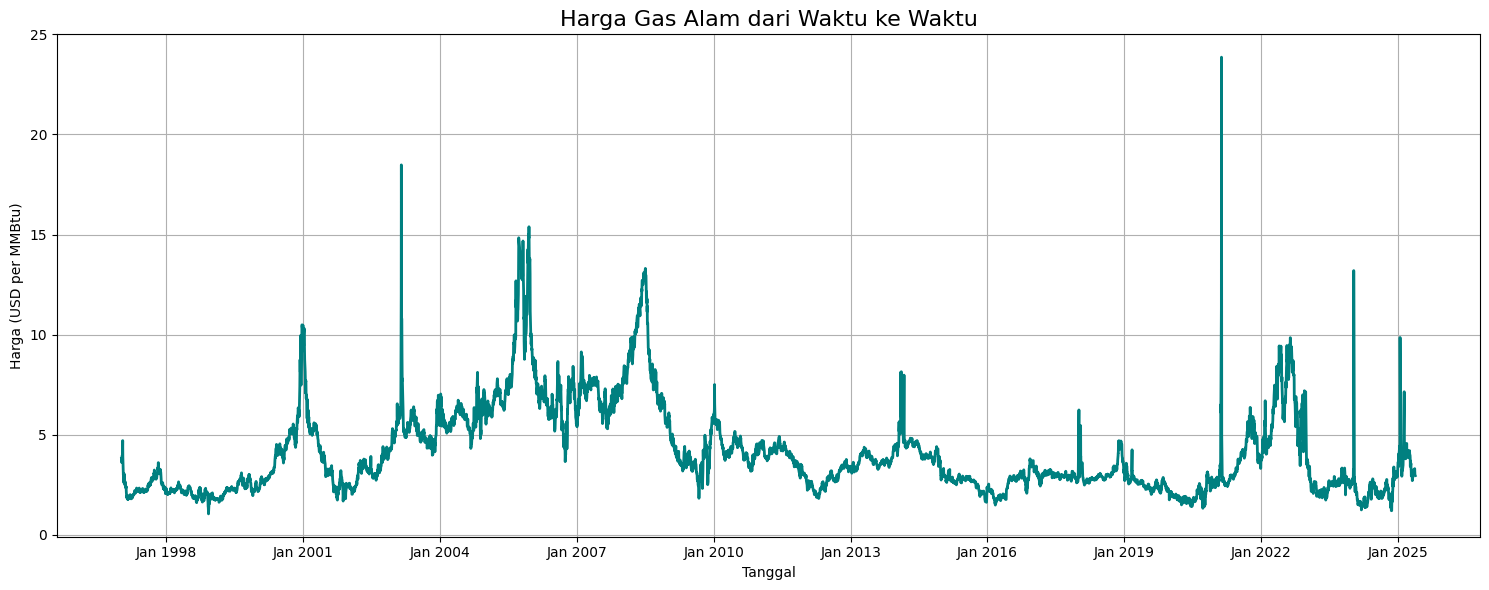

In [8]:
plt.figure(figsize=(15, 6))
plt.plot(df['Price'], color='teal', linewidth=2)
plt.title('Harga Gas Alam dari Waktu ke Waktu', fontsize=16)
plt.xlabel('Tanggal')
plt.ylabel('Harga (USD per MMBtu)')
plt.grid(True)

ax = plt.gca()

# Locator untuk tahun tiap 5 tahun, tapi cuma di bulan Desember
# Jadi pakai YearLocator(interval=5), lalu filter yang bulan Desember
# Untuk memastikan ticknya di Desember, kita bisa pakai YearLocator dan manual set bulan ke Des
ax.xaxis.set_major_locator(mdates.YearLocator(base=3, month=1, day=1))

# Format label "Dec 2000", "Dec 2005", ...
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.tight_layout()
plt.show()

## Standarisasi data

In [9]:
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(df)
print('Shape of the scaled data matrix: ', scaled_prices.shape)

Shape of the scaled data matrix:  (7127, 1)


In [10]:
np.isnan(scaled_prices).sum()

np.int64(0)

## Split train-test data

dalam notebook ini, akan digunakan window input dengan sequence length sepanjang 60 hari kebelakang

In [11]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 60  # 60 hari ke belakang
X, y = create_sequences(scaled_prices, window_size)

kemudian akan dilakukan penggecekan apakah ada nilai Nan atau infinite

In [12]:
print(np.isnan(X).sum(), np.isnan(y).sum())
print(np.isinf(X).sum(), np.isinf(y).sum())

0 0
0 0


dan hasilnya tidak ada. Selanjutnya akan dilakukan split data dengan perbandingan 80:20

In [13]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [14]:
X_train.shape  # hasil: (jumlah_sample, 60, 1)

(5653, 60, 1)

In [15]:
X_test.shape

(1414, 60, 1)

## Modelling LSTM

model dibentuk dengan evaluasi berbasis RMSE, MSE, dan MAE

In [16]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [17]:
model_lstm = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(64, activation='tanh', return_sequences=False),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse', metrics=['mse', rmse, 'mae'])
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

diterapkan Early Stop mencegah model tidak overfitting saat berlatih sebagai berikut

In [18]:
# Callback: EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',       # perhatikan loss pada data validasi
    patience=10,              # tunggu 10 epoch jika tidak membaik
    restore_best_weights=True
)

In [19]:
# Training dengan validation_split dan early stopping
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=100,              # disetel cukup tinggi, early stopping akan berhenti otomatis
    batch_size=32,
    validation_split=0.1,    # 10% data training dipakai untuk validasi
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.0057 - mae: 0.0449 - mse: 0.0057 - rmse: 0.0573 - val_loss: 2.5107e-04 - val_mae: 0.0113 - val_mse: 2.5107e-04 - val_rmse: 0.0131
Epoch 2/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 4.0569e-04 - mae: 0.0120 - mse: 4.0569e-04 - rmse: 0.0183 - val_loss: 1.8873e-04 - val_mae: 0.0077 - val_mse: 1.8873e-04 - val_rmse: 0.0098
Epoch 3/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 3.7485e-04 - mae: 0.0111 - mse: 3.7485e-04 - rmse: 0.0171 - val_loss: 1.6499e-04 - val_mae: 0.0061 - val_mse: 1.6499e-04 - val_rmse: 0.0084
Epoch 4/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 4.2424e-04 - mae: 0.0103 - mse: 4.2424e-04 - rmse: 0.0164 - val_loss: 1.6027e-04 - val_mae: 0.0062 - val_mse: 1.6027e-04 - val_rmse: 0.0083
Epoch 5/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 2.1938e-04 - mae: 0.0092 - mse: 2.1938e-04 - rmse: 0.0138 - val_loss: 1.5199e-04 - val_mae: 0.0055 - val_mse: 1.5199e-04 - val_rmse: 0.007

## Evaluasi Model

In [20]:
# Evaluasi model pada data test
test_loss, test_mse, test_rmse, test_mae = model_lstm.evaluate(X_test, y_test, verbose=1)

print("=== Evaluasi Model pada Data Test ===")
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MSE       : {test_mse:.4f}")
print(f"Test RMSE      : {test_rmse:.4f}")
print(f"Test MAE       : {test_mae:.4f}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.7515e-04 - mae: 0.0078 - mse: 9.7515e-04 - rmse: 0.0134
=== Evaluasi Model pada Data Test ===
Test Loss (MSE): 0.0010
Test MSE       : 0.0010
Test RMSE      : 0.0161
Test MAE       : 0.0093


In [21]:
y_pred = model_lstm.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


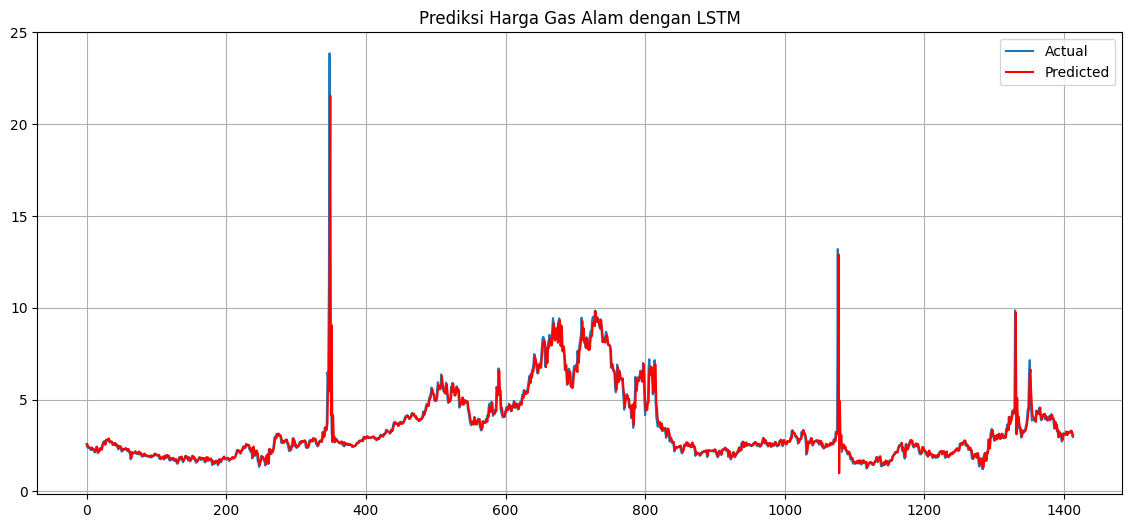

In [22]:
plt.figure(figsize=(14, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted', color='red')
plt.title('Prediksi Harga Gas Alam dengan LSTM')
plt.legend()
plt.grid(True)
plt.show()

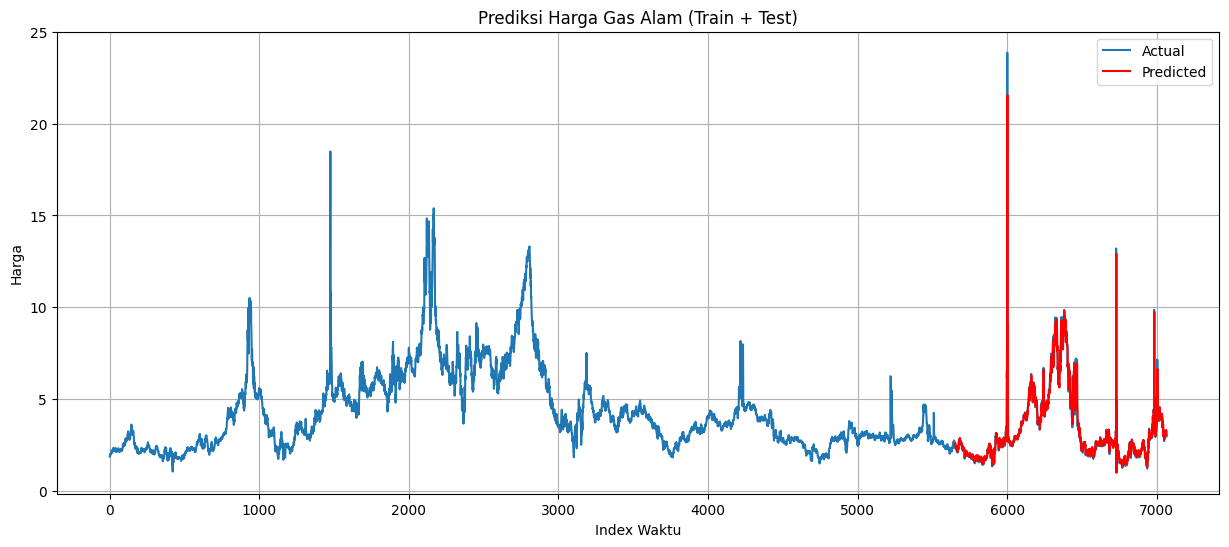

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Misal:
# y_train_inv: hasil inverse transform dari y_train
# y_pred_inv: hasil inverse transform dari prediksi y_test
# y_test_inv: hasil inverse transform dari y_test
y_train_inv = scaler.inverse_transform(y_train)

# Buat array kosong sepanjang total data
train_size = len(y_train_inv)
test_size = len(y_test_inv)
total_size = train_size + test_size

# Buat array untuk menyimpan hasil prediksi dalam urutan penuh
full_pred = np.empty((total_size,))
full_pred[:] = np.nan  # isi dengan NaN dulu
full_pred[train_size:] = y_pred_inv.flatten()  # isi hasil prediksi di bagian test

# Gabungkan y_train dan y_test untuk actual (aktual keseluruhan)
full_actual = np.concatenate((y_train_inv.flatten(), y_test_inv.flatten()))

# Plot
plt.figure(figsize=(15, 6))
plt.plot(full_actual, label='Actual')          # Garis aktual dari awal sampai akhir
plt.plot(full_pred, label='Predicted', color='red')  # Prediksi hanya di bagian test
plt.title('Prediksi Harga Gas Alam (Train + Test)')
plt.xlabel('Index Waktu')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.show()

## Forecasting ke depan s.d Januari 2028

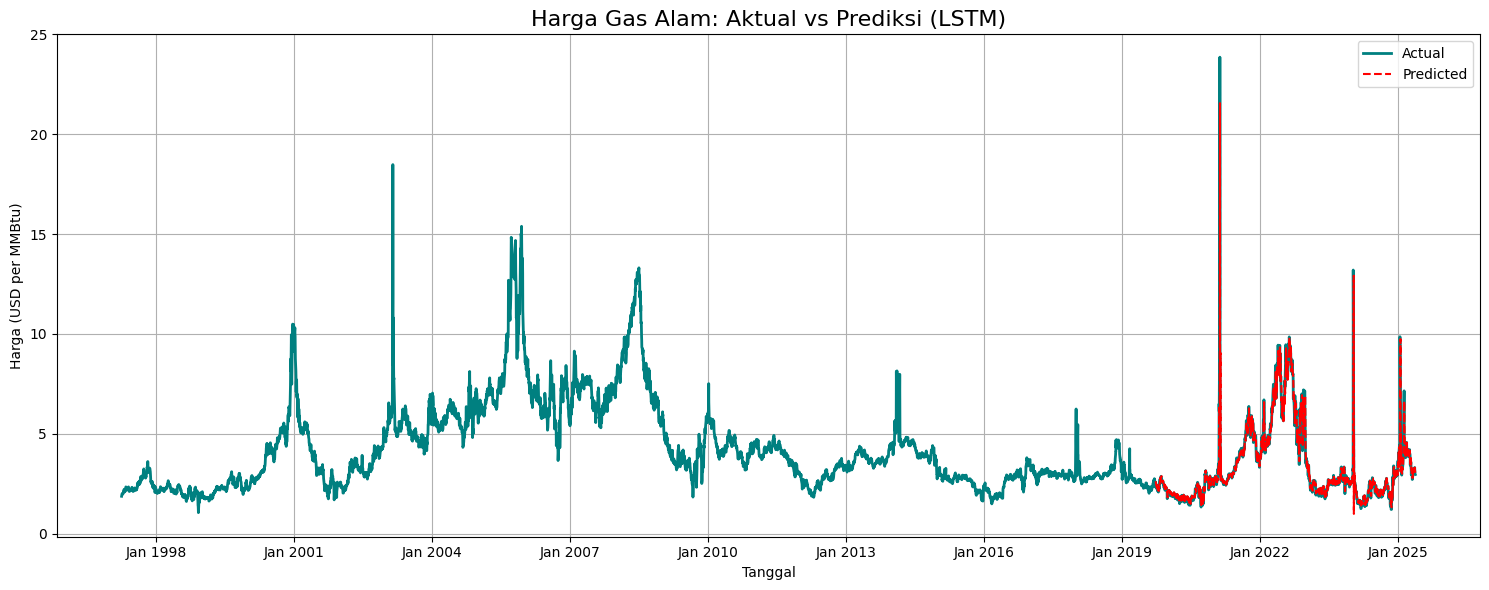

In [24]:
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt

# Pastikan y_train_inv, y_test_inv, y_pred_inv adalah array 1D (gunakan .flatten() jika perlu)

# Gabungkan data aktual
full_actual = np.concatenate((y_train_inv.flatten(), y_test_inv.flatten()))

# Buat array prediksi yang align dengan test saja
full_pred = np.empty_like(full_actual)
full_pred[:] = np.nan
full_pred[len(y_train_inv):] = y_pred_inv.flatten()

# Ambil index waktu dari df
# Pastikan panjangnya cocok dengan full_actual
date_index = df.index[-len(full_actual):]  # Ambil bagian akhir yang cocok panjangnya

# Plot
plt.figure(figsize=(15, 6))
plt.plot(date_index, full_actual, label='Actual', color='teal', linewidth=2)
plt.plot(date_index, full_pred, label='Predicted', color='red', linestyle='--')

plt.title('Harga Gas Alam: Aktual vs Prediksi (LSTM)', fontsize=16)
plt.xlabel('Tanggal')
plt.ylabel('Harga (USD per MMBtu)')
plt.grid(True)
plt.legend()

# Format tanggal (tiap 3 tahun, misalnya Januari)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=3, month=1, day=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.tight_layout()
plt.show()

In [25]:
# Jumlah bulan ke depan untuk diprediksi
n_future = 36

# Ambil window terakhir dari X_test
last_window = X_test[-1].reshape(window_size, 1)  # Pastikan bentuknya (60, 1)

future_predictions = []

for _ in range(n_future):
    # Prediksi 1 langkah ke depan
    next_pred = model_lstm.predict(last_window.reshape(1, window_size, 1), verbose=0)
    future_predictions.append(next_pred[0, 0])

    # Update window: geser 1 ke kiri dan tambahkan prediksi
    last_window = np.append(last_window[1:], [[next_pred[0, 0]]], axis=0)

# Inverse transform ke skala asli
future_predictions_inv = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Buat index tanggal masa depan
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_future, freq='MS')

# Buat DataFrame hasil prediksi
forecast_df = pd.DataFrame(future_predictions_inv, index=future_dates, columns=['Forecast'])

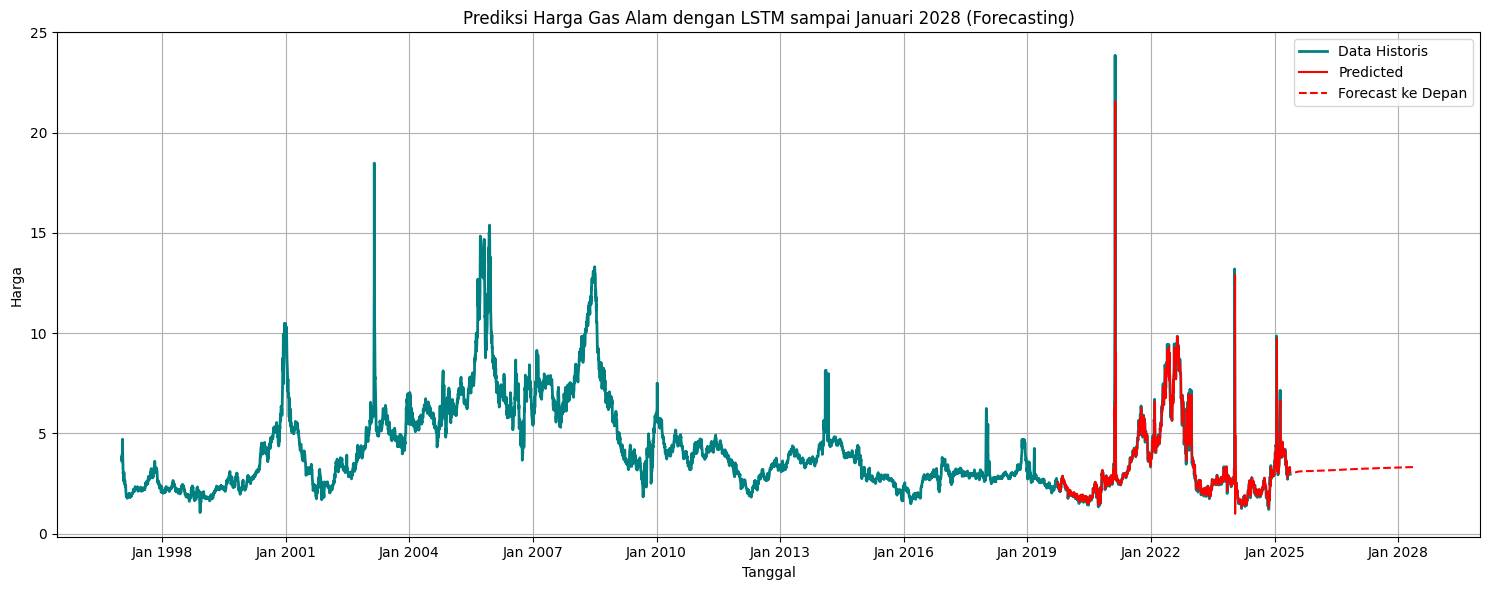

In [26]:
# Plot hasil prediksi masa depan
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Price'], label='Data Historis', linewidth=2, color='teal')
plt.plot(date_index, full_pred, label='Predicted', color='red')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast ke Depan', linestyle='--', color='red')

plt.title('Prediksi Harga Gas Alam dengan LSTM sampai Januari 2028 (Forecasting)')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)

# Format tanggal
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=3, month=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.tight_layout()
plt.show()

In [27]:
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price': future_predictions_inv.flatten()
})
forecast_df.set_index('Date', inplace=True)

## Inference Prediksi

In [28]:
forecast_df[-1:]

,Predicted Price
Date,
2028-06-01,3.322597


In [29]:
forecast_df.loc['2027-06-01']

,2027-06-01
Predicted Price,3.256494


In [30]:
forecast_df.loc['2026-06-01']

,2026-06-01
Predicted Price,3.164685


dengan model LSTM diprediksikan bahwa pada 06 Januari 2028, harga gas alam di level 3.32 USD/MMBtu.